In [1]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import os
from time import sleep
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm.notebook import tqdm
from absl import flags

## Relative imports
import astroddpm
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.separation import double_loader, method1_algo2, check_separation1score, separation1score, load_everything
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic import sde
from astroddpm.diffusion.models.network import ResUNet

from astroddpm.analysis.validationMetrics.powerSpectrum import compare_separation_power_spectrum_iso
import astroddpm.analysis.validationMetrics.powerSpectrum as powerspectrum

from scipy.signal import savgol_filter

import bm3d
from bm3d import bm3d, BM3DProfile, BM3DStages

In [2]:
amin,amax=(-6, 6)
bins = np.linspace(0, np.pi, 100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
MODEL_ID_1 = 'DiscreteSBM_VPSDE_MHD_BPROJ_N_4000_bottleneck_32'
MODEL_ID_2 = 'DiscreteSBM_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_32'

In [4]:
diffuser1 = load_everything(MODEL_ID_1)
diffuser2 = load_everything(MODEL_ID_2)

No model id found
Looking for the diffuser corresponding to model_id DiscreteSBM_VPSDE_MHD_BPROJ_N_4000_bottleneck_32 in the MODELS.json all config file
Loading the diffuser from a config dict.
Loading only the weights, no optimizer or scheduler.
No model id found
Looking for the diffuser corresponding to model_id DiscreteSBM_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_32 in the MODELS.json all config file
Loading the diffuser from a config dict.
Loading only the weights, no optimizer or scheduler.


In [5]:
COMPARISON_FOLDER = '/mnt/home/dheurtel/astroddpm/comparison_light/'

In [6]:
comp1 = torch.load(os.path.join(COMPARISON_FOLDER, MODEL_ID_1, 'comparison.pt'))
comp2 = torch.load(os.path.join(COMPARISON_FOLDER, MODEL_ID_2, 'comparison.pt'))

In [7]:
noise_min = 2e-2
noise_max = 1e2

noise_interp = 'log'
num_levels = 20

In [8]:
noise_min = max(noise_min, diffuser1.diffmodel.sde.noise_level(0).reshape(-1).cpu().numpy())
noise_max = min(noise_max, diffuser1.diffmodel.sde.noise_level(-1).reshape(-1).cpu().numpy())
bins = torch.linspace(0, np.pi, 100)

## Create the noise levels
if noise_interp == 'linear':
    noise_levels = np.linspace(noise_min, noise_max, num_levels)
elif noise_interp == 'log':
    noise_levels = np.logspace(np.log10(noise_min), np.log10(noise_max), num_levels)
else:
    raise NotImplementedError("noise_interp {} not implemented".format(noise_interp))

## Create the list of times from the noise levels by chosing the first time just above the noise level
diff_sde = diffuser1.diffmodel.sde
if isinstance(diff_sde, sde.DiscreteSDE):
    N = diff_sde.N
    all_times = np.arange(N)
    all_levels = diff_sde.noise_level(all_times).reshape(-1).cpu().numpy()
    times = np.zeros(num_levels, dtype=np.int64)
    for i, level in enumerate(noise_levels):
        times[i] = all_times[all_levels >= level][0]
noise_levels = diff_sde.noise_level(times).reshape(-1).cpu().numpy()

In [9]:
times, noise_levels

(array([   3,    9,   21,   46,   92,  170,  296,  485,  750, 1080, 1442,
        1797, 2127, 2426, 2698, 2948, 3180, 3396, 3600, 3793]),
 array([2.01852545e-02, 3.24924290e-02, 4.98623699e-02, 7.77380019e-02,
        1.21033527e-01, 1.88494712e-01, 2.95235872e-01, 4.61462110e-01,
        7.22806394e-01, 1.13094485e+00, 1.77119005e+00, 2.77116585e+00,
        4.34239531e+00, 6.79532957e+00, 1.06321173e+01, 1.66470451e+01,
        2.60844231e+01, 4.07996483e+01, 6.38976669e+01, 1.00001366e+02],
       dtype=float32))

In [42]:
signed_relative_error_bm3d = torch.zeros(1,len(bins)-1)

noise_level_cpu = noise_levels
power_spectrum = diffuser2.diffmodel.sde.power_spectrum.detach().cpu().numpy()
test_set = diffuser2.test_dataloader.dataset
i, time = 0, 3

with torch.no_grad():
    n = len(test_set)
    progress_bar = tqdm(total=n)
    progress_bar.set_description(f"Noise level n° {i}")
    for _, testimg in enumerate(test_set):
        testbatch = testimg.unsqueeze(0).unsqueeze(0).to(device)
        _, ps_true, _ = powerspectrum.power_spectrum_iso2d(testbatch, bins = bins, use_gpu=True)
        if ps_true.ndim == 2:
            ps_true = ps_true.reshape(-1)
        testbatch = testbatch.repeat(1, 1, 1, 1)
        timesteps = torch.full((testbatch.shape[0],), time).long().to(device)
        observation , _, _ = diffuser2.diffmodel.sde.sampling(testbatch, timesteps)
        observation = diffuser2.diffmodel.sde.rescale_preserved_to_additive(observation, timesteps)
        denoised_bm3d = torch.zeros_like(observation)
        for j in range(1):
            img = observation[j][0].cpu().numpy()
            denoised_bm3d[j,0, :, :] = torch.from_numpy(bm3d(img, sigma_psd = noise_level_cpu[i+1]*power_spectrum, stage_arg=BM3DStages.HARD_THRESHOLDING,)).to(device)
        _, ps_denoised, _= powerspectrum.power_spectrum_iso2d(denoised_bm3d, bins = bins, use_gpu=True)

        ps_denoised = ps_denoised.mean(dim=0,)
        signed_relative_error_bm3d[0] += ((ps_denoised.reshape(-1).cpu() - ps_true.reshape(-1).cpu()) / ps_true.reshape(-1).cpu())[:-1]
        progress_bar.update(1)
    signed_relative_error_bm3d[0] /= n
    progress_bar.close()

  0%|          | 0/100 [00:00<?, ?it/s]

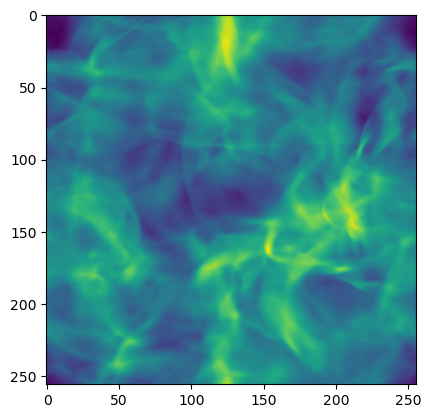

In [49]:
plt.imshow(denoised_bm3d.cpu()[0,0,:,:])

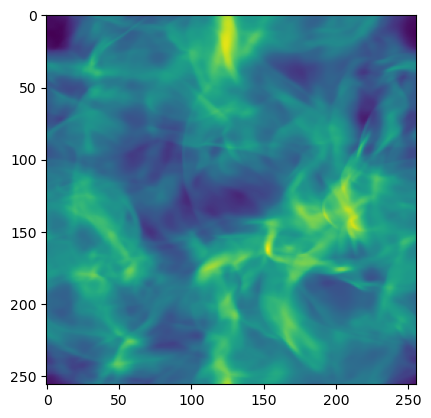

In [51]:
plt.imshow(testimg)

In [10]:
comp = comp2

In [45]:
comp2['bm3d'][0]=signed_relative_error_bm3d

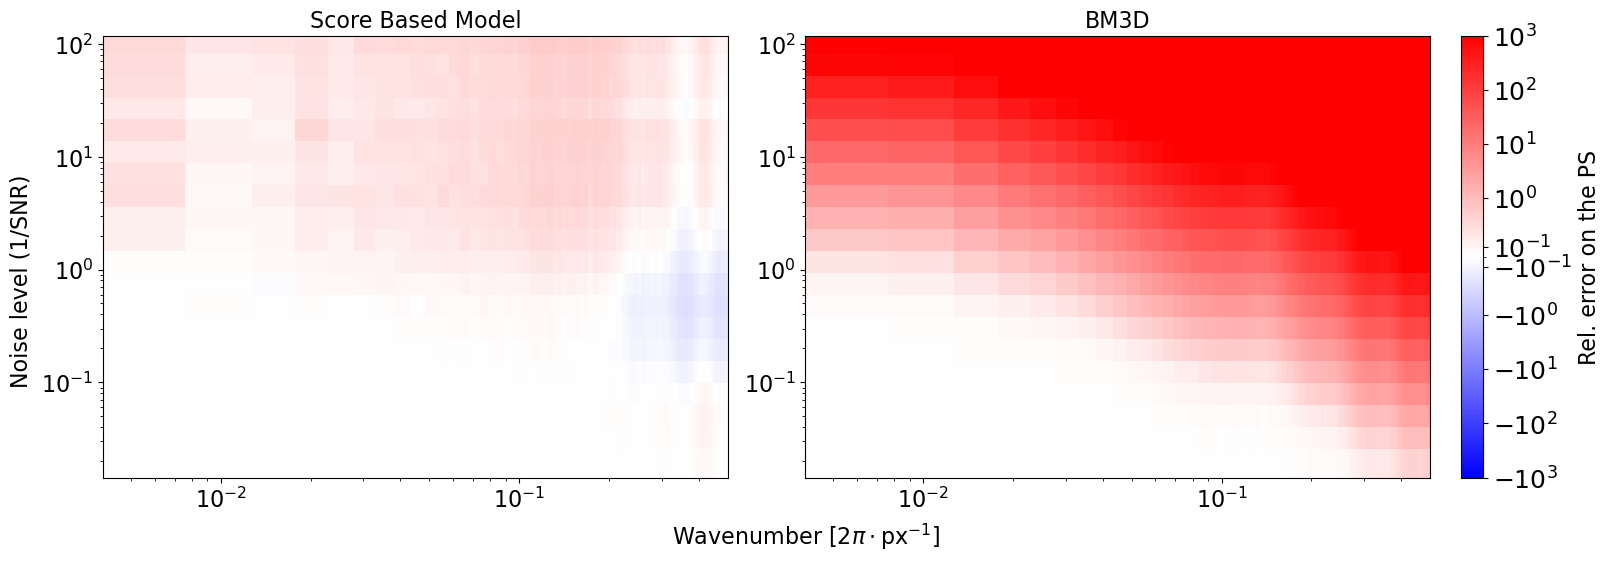

In [46]:
import matplotlib.colors as colors
keys = comp.keys()
nkeys = len(keys)
fig, axs = plt.subplots(1, nkeys, figsize=(nkeys * 8, 5.5), layout = 'constrained')

fontsize = 16

if nkeys == 1:
    # Assuming you have your data in the form of 2D array
    key = next(iter(keys))
    algorithm_goodness = comp[key]

    # Create an array of wavenumbers and noise levels
    wavenumbers = np.linspace(0, np.log10(np.pi), 99) 
    noise_levels = np.logspace(-2+np.log10(2), 2, 20)

    # Create a meshgrid for plotting
    Wavenumbers, Noise_levels = np.meshgrid(wavenumbers, noise_levels)

    # create an "invisible" scatter plot just for the logarithmic x-axis
    func_scatter = noise_levels.copy()
    func_scatter = np.repeat(func_scatter, 10)[:99]

    axs.scatter(wavenumbers,func_scatter, s=0)  # s=0 makes points invisible
    axs.set_xscale('log')
    axs.set_yscale('log')
    axs.set_xlabel('Wavenumber')
    axs.set_ylabel('Noise level (1/SNR)')
    method_name = 'Score Based Model' if key.lower() == 'sbm' else ('BM3D' if key.lower() == 'bm3d' else 'Unknown')
    axs.set_title(method_name, fontsize = fontsize)

    # create the actual heatmap
    c = axs.pcolormesh(Wavenumbers, Noise_levels, algorithm_goodness, shading='auto',cmap = 'seismic', vmin = -1, vmax = 1)

    fig.colorbar(c, ax=axs, label='Relative error on the Power Spectrum (with sign)', fontsize = fontsize)

    plt.show()

else:
    fig.supxlabel('Wavenumber [$2\pi\cdot\mathrm{px}^{-1}$]', fontsize = fontsize)
    fig.supylabel('Noise level (1/SNR)', fontsize = fontsize)
    for i, key in enumerate(keys):
        algorithm_goodness = comp[key]

        # Create an array of wavenumbers and noise levels
        wavenumbers = np.linspace(0, np.log10(np.pi), 99)
        noise_levels = np.logspace(-2+np.log10(2), 2, 20)

        # Create a meshgrid for plotting
        Wavenumbers, Noise_levels = np.meshgrid(wavenumbers, noise_levels)

        # create an "invisible" scatter plot just for the logarithmic x-axis
        func_scatter = noise_levels.copy()
        func_scatter = np.repeat(func_scatter, 10)[:99]

        axs[i].scatter(wavenumbers,func_scatter, s=0)
        axs[i].set_xscale('log')
        axs[i].set_yscale('log')
        method_name = 'Score Based Model' if key.lower() == 'sbm' else ('BM3D' if key.lower() == 'bm3d' else 'Unknown')
        axs[i].set_title(method_name, fontsize = fontsize)

        # create the actual heatmap

        c = axs[i].pcolormesh(Wavenumbers, Noise_levels, algorithm_goodness, shading='auto',norm=colors.SymLogNorm(linthresh=0.3, linscale=0.5,
                                              vmin=-1000.0, vmax=1000.0),
                       cmap='bwr')

        if i == nkeys -1:
            cbar = fig.colorbar(c, ax=axs[i])
            cbar.set_label('Rel. error on the PS', fontsize=fontsize)
            cbar.set_ticks([-1000,-100,-10,-1, -0.1, 0.1, 1, 10, 100,1000])
            cbar.ax.tick_params(labelsize=18)
    axs[0].tick_params(axis='both', which='major', labelsize=fontsize)
    axs[1].tick_params(axis='both', which='major', labelsize=fontsize)
    plt.savefig(os.path.join(os.path.dirname(os.path.dirname(astroddpm.__file__)),'images','Separation_PS_bias.pdf'))
    plt.show()

In [74]:
comp['bm3d']

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.5309e-05, -4.4807e-06, -1.8001e-05,  ...,  1.6399e+00,
          1.7034e+00,  1.7683e+00],
        [-3.5718e-04,  4.9130e-05, -1.2873e-04,  ...,  1.8315e+00,
          1.8168e+00,  1.8793e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])